In [1]:
# ✅ 0) Cài thư viện
!pip -q install kaggle ultralytics opencv-python matplotlib pandas pyyaml

import torch, platform, ultralytics, cv2, yaml, os, glob, shutil, json, time, matplotlib.pyplot as plt
print('CUDA:', torch.cuda.is_available(), '| Python:', platform.python_version(), '| Ultralytics:', ultralytics.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
CUDA: True | Python: 3.12.11 | Ultralytics: 8.3.204


In [2]:
# ⬆️ 0.1) Upload kaggle.json (Account → Create New API Token)
from google.colab import files
uploaded = files.upload()
assert 'kaggle.json' in uploaded, 'Hãy upload kaggle.json!'
import os, stat
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json','wb') as f: f.write(uploaded['kaggle.json'])
os.chmod('/root/.kaggle/kaggle.json', stat.S_IRUSR | stat.S_IWUSR)
print('✅ Kaggle token sẵn sàng.')

Saving kaggle.json to kaggle.json
✅ Kaggle token sẵn sàng.


In [3]:
# ⬇️ 1) Tải & giải nén IP102 YOLOv5 (YOLO-format)
KAGGLE_DATASET = 'leonidkulyk/ip102-yolov5'
!kaggle datasets download -d {KAGGLE_DATASET} -p /content -q
!unzip -q -o /content/ip102-yolov5.zip -d /content/ip102_yolo

# In cấu trúc
import os, itertools
def tree(p, depth=2):
    print(f'--- TREE: {p} ---')
    for root, dirs, files in itertools.islice(os.walk(p), 0, 100):
        lv = root.replace(p,'').count(os.sep)
        if lv>depth: continue
        ind='  '*lv
        print(f'{ind}{os.path.basename(root)}/')
        for f in sorted(files)[:6]: print(f'{ind}  {f}')
    print('--- END ---')
tree('/content/ip102_yolo', 3)

Dataset URL: https://www.kaggle.com/datasets/leonidkulyk/ip102-yolov5
License(s): unknown
--- TREE: /content/ip102_yolo ---
ip102_yolo/
  IP102_YOLOv5/
    ip102.yaml
    labels/
      train/
        IP000000000.txt
        IP000000002.txt
        IP000000003.txt
        IP000000008.txt
        IP000000010.txt
        IP000000031.txt
      val/
        IP000000108.txt
        IP000000322.txt
        IP000000354.txt
        IP000000446.txt
        IP000000544.txt
        IP000000557.txt
    images/
      train/
        IP000000000.jpg
        IP000000002.jpg
        IP000000003.jpg
        IP000000008.jpg
        IP000000010.jpg
        IP000000031.jpg
      val/
        IP000000108.jpg
        IP000000322.jpg
        IP000000354.jpg
        IP000000446.jpg
        IP000000544.jpg
        IP000000557.jpg
--- END ---


In [4]:
# 🧾 2) YAML 102 lớp
from pathlib import Path
DATA_ROOT = Path('/content/ip102_yolo/IP102_YOLOv5')
assert (DATA_ROOT/'images/train').exists() and (DATA_ROOT/'labels/train').exists()

names=None
try:
    names = yaml.safe_load(open(DATA_ROOT/'ip102.yaml')).get('names', None)
except Exception:
    names=None
if names is None: names = {i:f'class_{i}' for i in range(102)}

TEST_DIR = 'images/test' if (DATA_ROOT/'images/test').exists() else 'images/val'
yaml_path = Path('/content/ip102_102cls.yaml')
yaml.safe_dump({'path':str(DATA_ROOT),'train':'images/train','val':'images/val','test':TEST_DIR,'names':names},
               open(yaml_path,'w'), sort_keys=False, allow_unicode=True)
print('✅ Wrote:', yaml_path); print(open(yaml_path).read())

✅ Wrote: /content/ip102_102cls.yaml
path: /content/ip102_yolo/IP102_YOLOv5
train: images/train
val: images/val
test: images/val
names:
- rice leaf roller
- rice leaf caterpillar
- paddy stem maggot
- asiatic rice borer
- yellow rice borer
- rice gall midge
- Rice Stemfly
- brown plant hopper
- white backed plant hopper
- small brown plant hopper
- rice water weevil
- rice leafhopper
- grain spreader thrips
- rice shell pest
- grub
- mole cricket
- wireworm
- white margined moth
- black cutworm
- large cutworm
- yellow cutworm
- red spider
- corn borer
- army worm
- aphids
- Potosiabre vitarsis
- peach borer
- english grain aphid
- green bug
- bird cherry-oataphid
- wheat blossom midge
- penthaleus major
- longlegged spider mite
- wheat phloeothrips
- wheat sawfly
- cerodonta denticornis
- beet fly
- flea beetle
- cabbage army worm
- beet army worm
- Beet spot flies
- meadow moth
- beet weevil
- sericaorient alismots chulsky
- alfalfa weevil
- flax budworm
- alfalfa plant bug
- tarnishe

In [5]:
# 🚀 3) Train FULL 102 lớp
from ultralytics import YOLO
EPOCHS, IMGSZ, BATCH = 10, 640, 16
model = YOLO('yolov8n.pt')
res = model.train(data='/content/ip102_102cls.yaml', epochs=EPOCHS, imgsz=IMGSZ, batch=BATCH,
                  project='/content/runs_train', name='ip102_102cls', seed=42, exist_ok=True)
print('✅ Train done.')

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/ip102_102cls.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=ip102_102cls, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, po

In [6]:
# 📈 4) Evaluate → hiển thị & lưu metrics JSON
from ultralytics import YOLO
import os, json, pandas as pd, matplotlib.pyplot as plt
best_ckpt='/content/runs_train/ip102_102cls/weights/best.pt'
assert os.path.exists(best_ckpt), 'best.pt chưa có.'
best = YOLO(best_ckpt)
metrics = best.val(data='/content/ip102_102cls.yaml', imgsz=640, batch=16)
print(metrics)

EXPORTS='/content/exports_102cls'; os.makedirs(EXPORTS, exist_ok=True)
json.dump(metrics.results_dict, open(f'{EXPORTS}/metrics_102cls.json','w'), indent=2)

# Hiển thị bảng metrics gọn
vals = {
    'Precision': metrics.results_dict.get('metrics/precision(B)', metrics.results_dict.get('precision',0)),
    'Recall': metrics.results_dict.get('metrics/recall(B)', metrics.results_dict.get('recall',0)),
    'mAP@0.5': metrics.results_dict.get('metrics/mAP50(B)', metrics.results_dict.get('map50',0)),
    'mAP@0.5:0.95': metrics.results_dict.get('metrics/mAP50-95(B)', metrics.results_dict.get('map',0)),
}
import pandas as pd
df = pd.DataFrame(list(vals.items()), columns=['Metric','Value'])
display(df)

Ultralytics 8.3.204 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,341,330 parameters, 0 gradients, 9.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 836.6±737.9 MB/s, size: 23.2 KB)
val: Scanning /content/ip102_yolo/IP102_YOLOv5/labels/val.cache... 1329 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1329/1329 2.2Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 84/84 6.8it/s 12.3s
                   all       1329       1621      0.478      0.481      0.431      0.261
      rice leaf roller         12         13      0.437          1      0.831      0.582
 rice leaf caterpillar          8          8          0          0      0.087     0.0552
     paddy stem maggot          2          2          1          0      0.398      0.219
    asiatic rice borer         12         13      0.289      0.462      0.292      0.187
     yellow rice borer          6

,Metric,Value
0,Precision,0.478270
1,Recall,0.481403
2,mAP@0.5,0.430621
3,mAP@0.5:0.95,0.261308


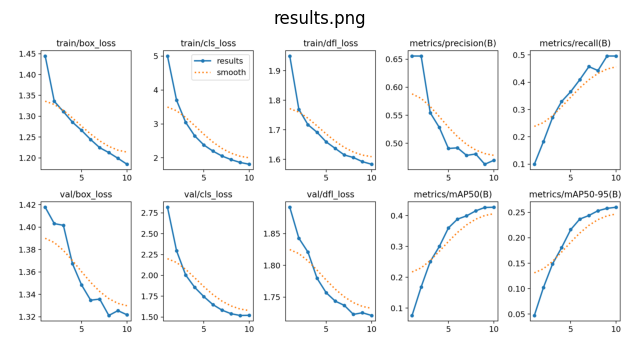

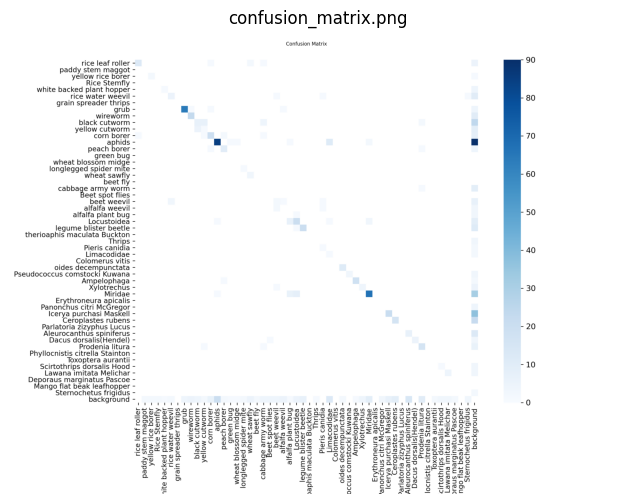

Curves saved to: /content/exports_102cls/curves


In [7]:
# 📊 5) Gom curves & hiển thị trực tiếp một số hình chính
import os, glob, shutil, matplotlib.pyplot as plt, matplotlib.image as mpimg
SRC='/content/runs_train/ip102_102cls'; DST='/content/exports_102cls/curves'
os.makedirs(DST, exist_ok=True)
picked = ['confusion_matrix.png','PR_curve.png','F1_curve.png','P_curve.png','R_curve.png','results.png']
found = {}
for root,dirs,files in os.walk(SRC):
    for f in files:
        if f in picked:
            src=os.path.join(root,f); dst=os.path.join(DST,f)
            shutil.copy2(src,dst); found[f]=dst

# Hiển thị
for k, path in found.items():
    try:
        img = mpimg.imread(path)
        plt.figure(figsize=(8,6)); plt.imshow(img); plt.axis('off'); plt.title(k)
        plt.show()
    except Exception as e:
        print('Skip show', k, e)

print('Curves saved to:', DST)


image 1/1 /content/ip102_yolo/IP102_YOLOv5/images/val/IP070000248.jpg: 448x640 1 Cicadella viridis, 1 Cicadellidae, 74.3ms
Speed: 3.8ms preprocess, 74.3ms inference, 2.1ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/ip102_yolo/IP102_YOLOv5/images/val/IP050000127.jpg: 480x640 1 lytta polita, 1 legume blister beetle, 1 blister beetle, 81.6ms
Speed: 3.4ms preprocess, 81.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/ip102_yolo/IP102_YOLOv5/images/val/IP049000821.jpg: 448x640 1 Locustoidea, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/ip102_yolo/IP102_YOLOv5/images/val/IP041000042.jpg: 480x640 (no detections), 8.9ms
Speed: 3.8ms preprocess, 8.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/ip102_yolo/IP102_YOLOv5/images/val/IP102003975.jpg: 544x640 1 Cicadellidae, 67.5ms
Speed: 3.4ms preprocess, 67.5ms inf

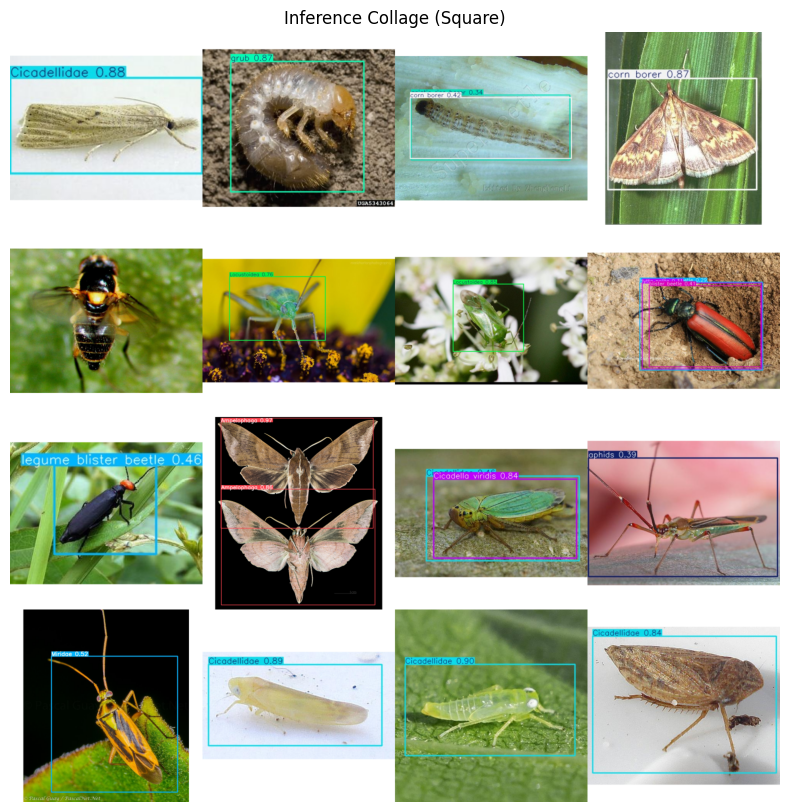

✅ Collage saved: /content/exports_102cls/preds_collage_square.png


In [8]:
# 🖼️ 6) Inference + collage vuông (hiển thị trực tiếp)
import os, glob, cv2, math, numpy as np, matplotlib.pyplot as plt
from ultralytics import YOLO
best=YOLO('/content/runs_train/ip102_102cls/weights/best.pt')

pred_dir='/content/exports_102cls/preds'; os.makedirs(pred_dir, exist_ok=True)
paths=glob.glob('/content/ip102_yolo/IP102_YOLOv5/images/test/*.jpg')
if not paths: paths=glob.glob('/content/ip102_yolo/IP102_YOLOv5/images/val/*.jpg')

for p in paths[:16]:
    r=best.predict(source=p, imgsz=640, conf=0.25, save=False)
    im=r[0].plot()
    cv2.imwrite(os.path.join(pred_dir, os.path.basename(p)), im)

def pad_sq(img, fill=255):
    h,w=img.shape[:2]; s=max(h,w)
    can=np.full((s,s,3), fill, dtype=np.uint8)
    y=(s-h)//2; x=(s-w)//2; can[y:y+h,x:x+w]=img; return can

imgs=sorted(glob.glob(os.path.join(pred_dir,'*.*')))[:16]
assert imgs, f'Không có ảnh trong {pred_dir}'
CELL=384; cols=rows=math.ceil(math.sqrt(len(imgs)))
grid=np.full((rows*CELL, cols*CELL,3),255,dtype=np.uint8)
for i,p in enumerate(imgs):
    bgr=cv2.imread(p); rgb=cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    rgb=pad_sq(rgb,255); rgb=cv2.resize(rgb, (CELL,CELL), interpolation=cv2.INTER_AREA)
    r,c=divmod(i, cols); grid[r*CELL:(r+1)*CELL, c*CELL:(c+1)*CELL]=rgb

coll='/content/exports_102cls/preds_collage_square.png'
cv2.imwrite(coll, cv2.cvtColor(grid, cv2.COLOR_RGB2BGR))

plt.figure(figsize=(10,10)); plt.imshow(grid); plt.axis('off'); plt.title('Inference Collage (Square)'); plt.show()
print('✅ Collage saved:', coll)

In [9]:
# 📋 7) Xuất bảng Markdown/LaTeX để copy vào Word/LaTeX
import json, os
mp='/content/exports_102cls/metrics_102cls.json'; d=json.load(open(mp))

def pick(d,*k):
    for x in k:
        if x in d: return d[x]
    return 0.0
precision=pick(d,'metrics/precision(B)','precision')
recall=pick(d,'metrics/recall(B)','recall')
map50=pick(d,'metrics/mAP50(B)','map50')
map5095=pick(d,'metrics/mAP50-95(B)','map')

md=f"""| Metric       | Value |
|--------------|-------|
| Precision    | {precision:.4f} |
| Recall       | {recall:.4f} |
| mAP@0.5      | {map50:.4f} |
| mAP@0.5:0.95 | {map5095:.4f} |"""
tex=f"""\\begin{{table}}[h]
\\centering
\\begin{{tabular}}{{|c|c|}}
\\hline
Metric & Value \\ \\hline
Precision & {precision:.4f} \\
Recall & {recall:.4f} \\
mAP@0.5 & {map50:.4f} \\
mAP@0.5:0.95 & {map5095:.4f} \\
\\hline
\\end{{tabular}}
\\caption{{Evaluation Metrics for YOLOv8 on IP102 (102-class)}}
\\label{{tab:yolo_ip102_102cls_metrics}}
\\end{{table}}"""

os.makedirs('/content/exports_102cls/tables', exist_ok=True)
open('/content/exports_102cls/tables/metrics_102cls.md','w').write(md)
open('/content/exports_102cls/tables/metrics_102cls.tex','w').write(tex)

print('=== Markdown Table ===\n', md)
print('\n=== LaTeX Table ===\n', tex)
print('\nSaved to /content/exports_102cls/tables')

=== Markdown Table ===
 | Metric       | Value |
|--------------|-------|
| Precision    | 0.4783 |
| Recall       | 0.4814 |
| mAP@0.5      | 0.4306 |
| mAP@0.5:0.95 | 0.2613 |

=== LaTeX Table ===
 \begin{table}[h]
\centering
\begin{tabular}{|c|c|}
\hline
Metric & Value \ \hline
Precision & 0.4783 \ 
Recall & 0.4814 \ 
mAP@0.5 & 0.4306 \ 
mAP@0.5:0.95 & 0.2613 \ 
\hline
\end{tabular}
\caption{Evaluation Metrics for YOLOv8 on IP102 (102-class)}
\label{tab:yolo_ip102_102cls_metrics}
\end{table}

Saved to /content/exports_102cls/tables


In [2]:
from ultralytics import YOLO
import os, glob, shutil, matplotlib.pyplot as plt, matplotlib.image as mpimg

BEST = '/content/runs_train/ip102_102cls/weights/best.pt'
DATA = '/content/ip102_102cls.yaml'
assert os.path.exists(BEST), "Không tìm thấy best.pt — hãy train trước."

# chạy lại val với plots=True để YOLO sinh hình
model = YOLO(BEST)
_ = model.val(
    data=DATA, imgsz=640, batch=16,
    plots=True,                               # << quan trọng
    project='/content/runs_eval',             # tách thư mục eval cho dễ tìm
    name='ip102_102cls_eval',
    exist_ok=True
)

# 2) Tìm 4 file đường cong và copy về exports_102cls/curves
SRC_DIRS = [
    '/content/runs_eval/ip102_102cls_eval',
    '/content/runs_train/ip102_102cls'
]
DST = '/content/exports_102cls/curves'
os.makedirs(DST, exist_ok=True)

wanted = {
    'P_curve.png' : 'Hinh4_4_Precision-Confidence_Curve.png',
    'R_curve.png' : 'Hinh4_5_Recall-Confidence_Curve.png',
    'PR_curve.png': 'Hinh4_2_Precision-Recall_Curve.png',
    'F1_curve.png': 'Hinh4_3_F1-Confidence_Curve.png',
}
found_paths = {}

for w in wanted:
    for base in SRC_DIRS:
        for fp in glob.glob(f'{base}/**/{w}', recursive=True):
            found_paths[w] = fp
            break
    if w not in found_paths:
        print(f'⚠️ Không tìm thấy {w}')

# copy + hiển thị
for w, src in found_paths.items():
    dst = os.path.join(DST, wanted[w])
    shutil.copy2(src, dst)
    img = mpimg.imread(dst)
    plt.figure(figsize=(8,6))
    plt.imshow(img); plt.axis('off'); plt.title(wanted[w].replace("_"," "))
    plt.show()
    print('✅ Saved:', dst)

print("\n➡️ Thư mục chèn vào báo cáo:", DST)


ModuleNotFoundError: No module named 'ultralytics'